## Imports 📦

In [1]:
import pandas as pd
import numpy as np
import emoji
import warnings
import nltk
from nltk.corpus import stopwords    
import string
import statistics

In [2]:
from matplotlib import pyplot as plt
import math
import seaborn as sns
import statistics

In [3]:
warnings.filterwarnings('ignore')

## Load Data 💿

In [4]:
df = pd.read_csv("Data/cleaned_by_language.csv")

In [5]:
en_df = df[df['language'] == 'en']
es_df = df[df['language'] == 'es']

In [6]:
en_comment = en_df['text only'].to_list()
es_comment = es_df['text only'].to_list()
en_comment_with_emoji = en_df['text'].to_list()
es_comment_with_emoji = es_df['text'].to_list()

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
en_stop_words = set(stopwords.words('english'))
es_stop_words = set(stopwords.words('spanish'))

def filter_comments(comment_list, stop_words):
    filtered_comments = []

    for comment in comment_list:
        # remove word starts with @
        comment = " ".join(filter(lambda x:x[0]!='@', comment.split()))
    
        # remove punctuations
        comment = comment.translate(str.maketrans('', '', string.punctuation))

        # remove stopwords
        words = nltk.word_tokenize(comment)
        filtered_comment = [word for word in words if word.lower() not in stop_words]
        filtered_comment = ' '.join(filtered_comment)
        filtered_comment = comment
        filtered_comments.append(filtered_comment)
    return filtered_comments

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aorawancraprayoon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aorawancraprayoon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
en_filtered_comments = filter_comments(en_comment, en_stop_words)
es_filtered_comments = filter_comments(es_comment, es_stop_words)
en_with_emoji_filtered_comments = filter_comments(en_comment_with_emoji, en_stop_words)
es_with_emoji_filtered_comments = filter_comments(es_comment_with_emoji, es_stop_words)

## Text Embeddings using LASER - this pretrained model supports cross-lingual tasks and embeds in setence-level

In [9]:
pip install laserembeddings

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
!/usr/bin/python3 -m laserembeddings download-models


✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

✨ You're all set!


In [11]:
# run this in terminal first: python -m laserembeddings download-models
from laserembeddings import Laser

laser = Laser()
en_text_array = laser.embed_sentences(en_filtered_comments, lang='en')
es_text_array = laser.embed_sentences(es_filtered_comments, lang='es')
en_array = laser.embed_sentences(en_with_emoji_filtered_comments, lang='en')
es_array = laser.embed_sentences(es_with_emoji_filtered_comments, lang='es')

In [12]:
en_text_array.shape

(280, 1024)

In [13]:
en_array.shape

(280, 1024)

## Emoji Embeddings using Emoji2Vec

In [14]:
from gensim.models import KeyedVectors

# Load pretrained emoji embeddings
emoji_model = KeyedVectors.load_word2vec_format('emoji2vec.bin', binary=True)

def emoji_embedding(df):
    emoji_list_list = df['emoji list'].to_list()

    # Initialize a list to store emoji embeddings
    emoji_embedding = []

    for emoji_list in emoji_list_list:
        emoji_list_embedding = []  # Initialize a list for embeddings of each emoji list
        for emoji in emoji_list:
            try:
                emoji_list_embedding.append(emoji_model[emoji])
                
            except KeyError:
                pass

            # if len(emoji_list_embedding) != 0:
            # emoji_list_embedding = np.concatenate(emoji_list_embedding, axis=0)
        emoji_embedding.append(emoji_list_embedding)
    
    # average
    res = []
    for embeddings in emoji_embedding:
        average_embedding = np.mean(embeddings, axis=0)
        # padded arrays with zero emojis with a length 300 array filled with zeros
        if average_embedding is None or np.isnan(average_embedding).all():
            res.append(np.zeros(300))
        else:
            res.append(average_embedding)
    
    return np.array(res)

# en_max_size = max(len(arr) for arr in en_emoji_embedding)
# en_padded_arrays = [np.pad(arr, (0, en_max_size - len(arr)), 'constant') for arr in en_emoji_embedding]
# en_emoji_array = np.vstack(en_padded_arrays)

In [15]:
en_emoji_array = emoji_embedding(en_df)
es_emoji_array = emoji_embedding(es_df)

In [16]:
es_emoji_array.shape

(280, 300)

##  Testing to see how many unique emojis in each comment (Don't run this part) 🧪

In [17]:
# def emoji_embedding(df):
#     emoji_list_list = df['emoji list'].to_list()

#     # Initialize a list to store emoji embeddings
#     emoji_embedding = []
#     emoji_count = []
#     emoji_list_l = []

#     for emoji_list in emoji_list_list:
#         emoji_l = []
#         emoji_list_embedding = []  # Initialize a list for embeddings of each emoji list
#         count = 0
#         for emoji in emoji_list:
#             try:
#                 emoji_list_embedding.append(emoji_model[emoji])
#                 emoji_l.append(emoji)
#                 count+=1
                
#             except KeyError:
#                 pass
#         emoji_list_l.append(emoji_l)
#         emoji_count.append(count)

#         if len(emoji_list_embedding) != 0:
#             emoji_list_embedding = np.concatenate(emoji_list_embedding, axis=0)
#         emoji_embedding.append(emoji_list_embedding)

#     return emoji_count, emoji_embedding, emoji_list_l

In [18]:
# en_emoji_count, en_emoji_embedding, es_emoji = emoji_embedding(en_df)
# es_emoji_count, es_emoji_embedding, en_emoji = emoji_embedding(es_df)

In [19]:
# list1 = []
# for i in es_emoji:
#     unique_set = set(i)
#     unique_list = list(unique_set)
#     list1.append(unique_list)
# list1 # a list of unique emojis in each comment (that can be handled by emoji2vec)
# counts = [len(inner_list) for inner_list in list1]

# zero_count = 0

# for item in counts:
#     if item == 0:
#         zero_count += 1
# zero_count

In [20]:
# list2 = []
# for i in en_emoji:
#     unique_set = set(i)
#     unique_list = list(unique_set)
#     list2.append(unique_list)
# list2 # a list of unique emojis in each comment (that can be handled by emoji2vec)
# counts2 = [len(inner_list) for inner_list in list2]

# zero_count2 = 0

# for item in counts2:
#     if item == 0:
#         zero_count2 += 1
# zero_count2

## Concatenate the text embeddings and emoji embeddings 

In [21]:
# Concatenate along columns (horizontally)
en_embeddings = np.concatenate((en_text_array, en_emoji_array), axis=1)
es_embeddings = np.concatenate((es_text_array, es_emoji_array), axis=1)

In [22]:
en_embeddings.shape

(280, 1324)

In [23]:
en_emoji_array.shape

(280, 300)

## Embedding Distributions 📊

In [113]:
def make_dist_df(arr):
    df = pd.DataFrame(arr)
    df['average'], df['min'], df['max']  = 0, 0, 0
    for idx, row in df.iterrows():
        df.at[idx, 'average'] = statistics.mean(row)
        df.at[idx, 'min'] = min(row)
        df.at[idx, 'max'] = max(row)
    return df

def df_embeddings(en_text_array, es_text_array, en_emoji_array, es_emoji_array):
    en_text_df = make_dist_df(en_text_array)
    en_text_df['type'] = 'en_text'
    es_text_df = make_dist_df(es_text_array)
    es_text_df['type'] = 'es_text'
    en_emoji_df = make_dist_df(en_emoji_array)
    en_emoji_df['type'] = 'en_emoji'
    es_emoji_df = make_dist_df(es_emoji_array)
    es_emoji_df['type'] = 'es_emoji'

    all_df = pd.concat([en_text_df[['min','max','average','type']],
                        es_text_df[['min','max','average','type']],
                        en_emoji_df[['min','max','average','type']],
                        es_emoji_df[['min','max','average','type']]])
    return all_df

(-0.15, 0.48)

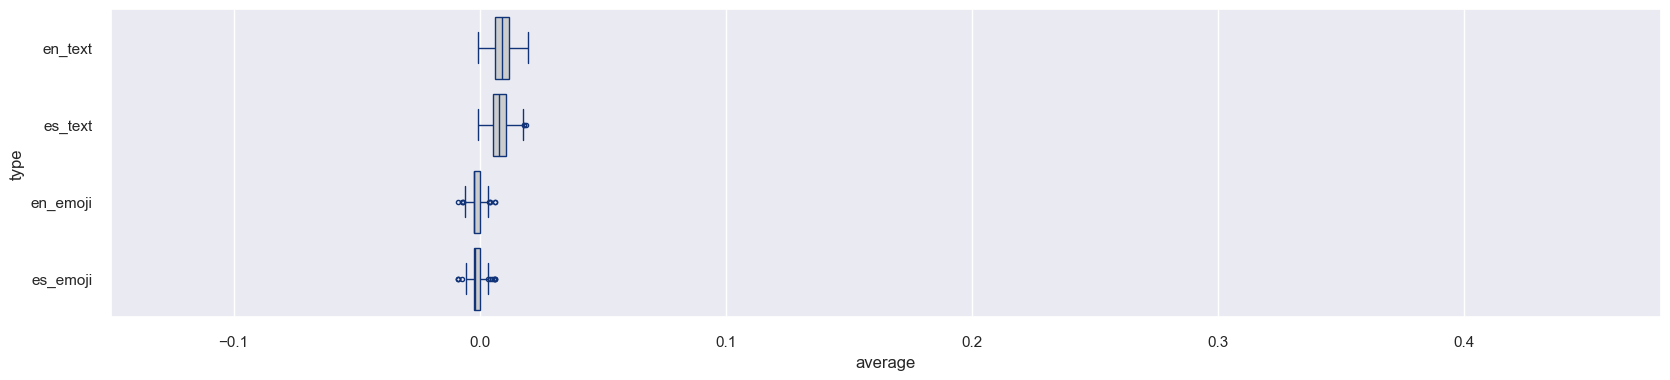

In [136]:
dist_df = df_embeddings(en_text_array, es_text_array, en_emoji_array, es_emoji_array)
sns.set(rc={'figure.figsize':(20,4)})

fig, ax = plt.subplots()
sns.boxplot(data=dist_df, x='average', y='type', color=".8", linecolor="#137", flierprops={"marker": "."})
ax.set_xlim(-0.15, 0.48)

(-0.15, 0.48)

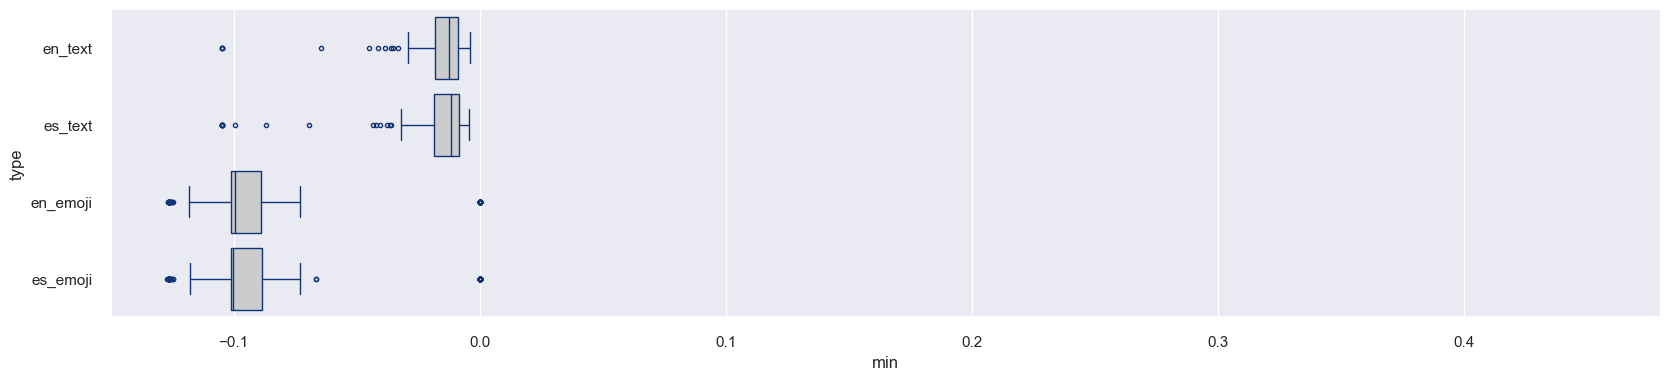

In [137]:
fig, ax = plt.subplots()
sns.boxplot(data=dist_df, x='min', y='type', color=".8", linecolor="#137", flierprops={"marker": "."})
ax.set_xlim(-0.15, 0.48)

(-0.15, 0.48)

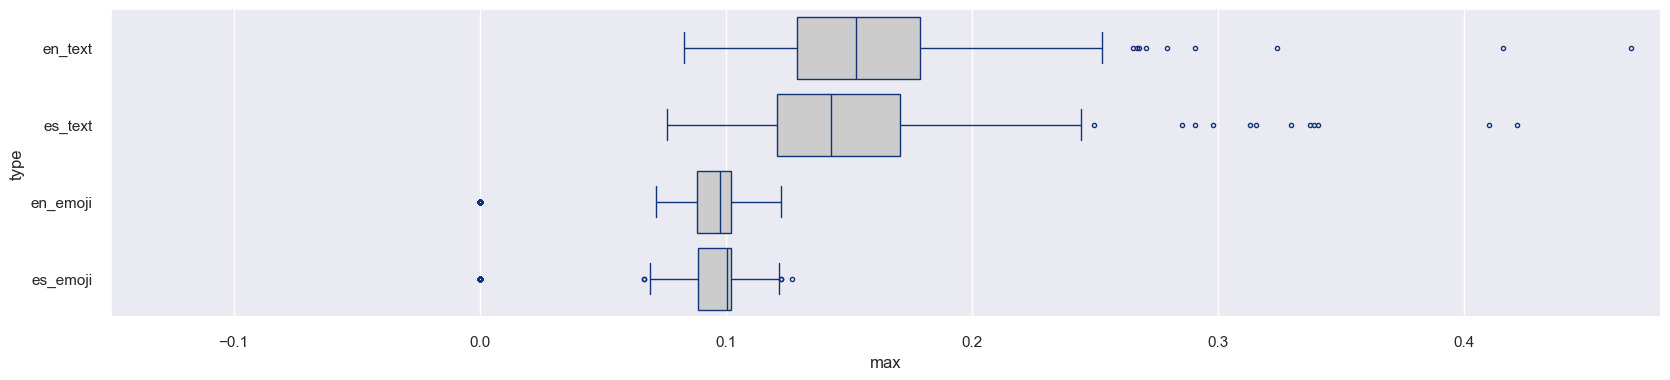

In [138]:
fig, ax = plt.subplots()
sns.boxplot(data=dist_df, x='max', y='type', color=".8", linecolor="#137", flierprops={"marker": "."})
ax.set_xlim(-0.15, 0.48)

## Variable names 📇
- en_text_array: LASER embeddings on text only (shape:280x1024)
- en_emoji_array: emoji2vec embeddings on emoji only (shape: 280x300)
- en_embeddings: concatenate en_text_array and en_emoji_array (shape: 280, 1324)
- en_array: LASER embeddings on text+emoji (shape: 280x1024)
- (replace en by es to get result from Spanish dataset)


## Try clustering using minibatch Kmeans -- concatenated word + emoji embeddings

In [24]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

### Determine optimal number of clusters

#### Distortion Score Elbow
- based on calculating the Within-Cluster-Sum of Squared Errors (WSS) for different number of clusters (k) and selecting the k for which change in WSS first starts to diminish.

In [25]:
pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


English

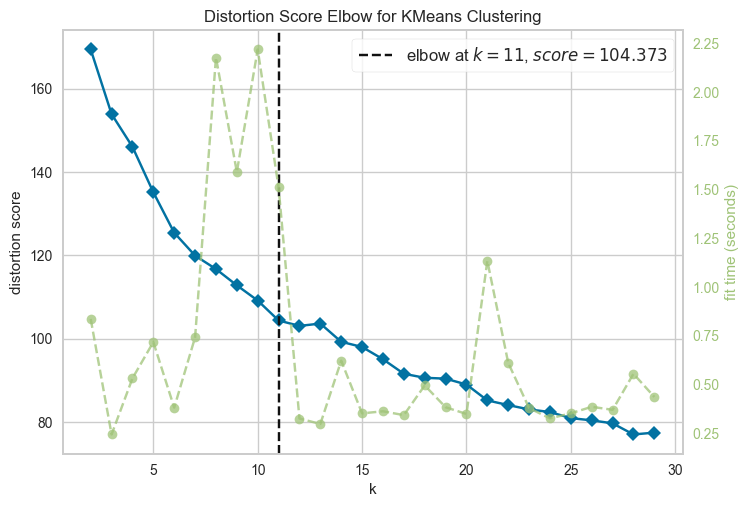

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
# referenced https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(en_embeddings)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

Spanish

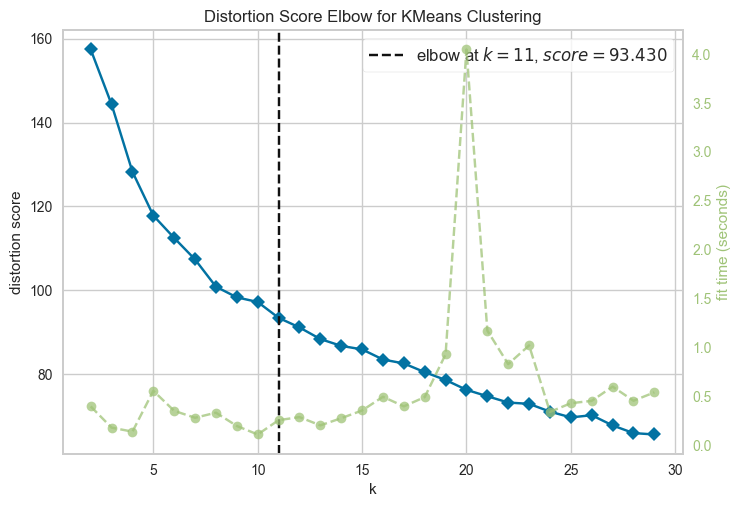

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
# referenced https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(es_embeddings)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

#### Silhouette Coefficient Method

English

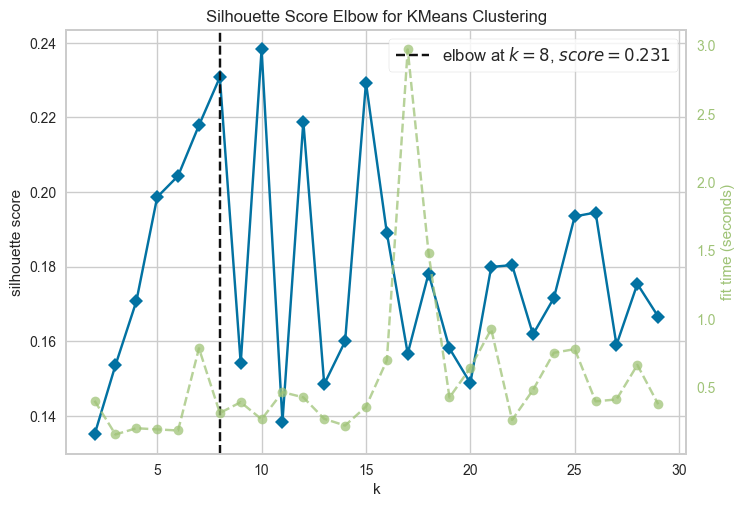

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [28]:
# Silhouette Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(en_embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Spanish

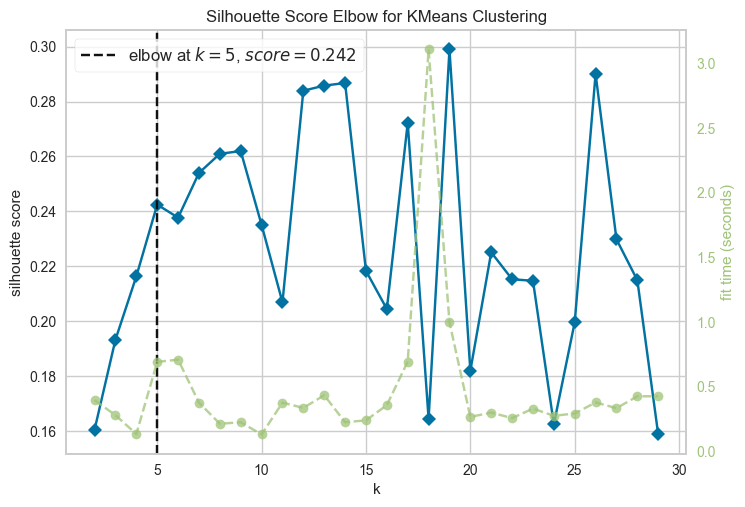

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [29]:
# Silhouette Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(es_embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

#### Calinski-Harabasz Index

English

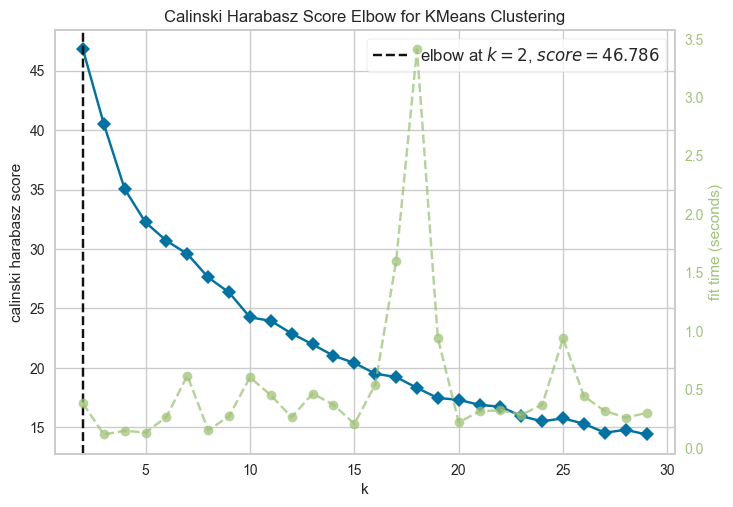

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [30]:
# Calinski Harabasz Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(en_embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Spanish

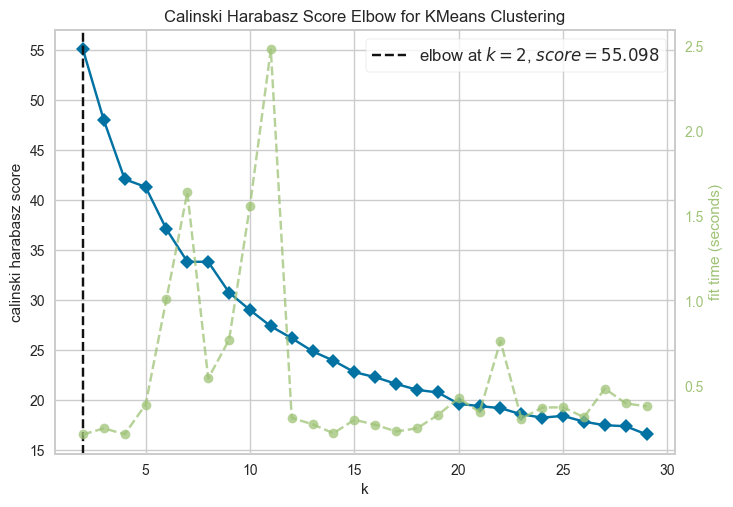

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [31]:
# Calinski Harabasz Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(es_embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Clustering Functions

In [32]:
# code from https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/
def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [33]:
def apply_cluster(lang_embeddings, lang_df, lang_filtered_comments, k):
    clustering, cluster_labels = mbkmeans_clusters(
        X=lang_embeddings,
        k=k,
        mb=500,
        print_silhouette_values=True,
    )
    df_clusters = pd.DataFrame({
        "text": lang_df['text'],
        "tokens": [" ".join(text) for text in lang_filtered_comments],
        "cluster": cluster_labels
    })
    return df_clusters

### English Results

In [34]:
en_df_clusters = apply_cluster(en_embeddings, en_df, en_filtered_comments, 11)

For n_clusters = 11
Silhouette coefficient: 0.16
Inertia:106.87608377317548
Silhouette values:
    Cluster 10: Size:23 | Avg:0.46 | Min:0.17 | Max: 0.53
    Cluster 9: Size:6 | Avg:0.46 | Min:0.42 | Max: 0.49
    Cluster 7: Size:15 | Avg:0.44 | Min:0.20 | Max: 0.51
    Cluster 4: Size:7 | Avg:0.39 | Min:0.04 | Max: 0.46
    Cluster 2: Size:13 | Avg:0.35 | Min:0.18 | Max: 0.40
    Cluster 3: Size:24 | Avg:0.29 | Min:0.02 | Max: 0.46
    Cluster 0: Size:34 | Avg:0.26 | Min:0.05 | Max: 0.39
    Cluster 1: Size:29 | Avg:0.10 | Min:0.03 | Max: 0.19
    Cluster 5: Size:49 | Avg:0.08 | Min:-0.03 | Max: 0.21
    Cluster 8: Size:11 | Avg:0.03 | Min:-0.11 | Max: 0.10
    Cluster 6: Size:69 | Avg:-0.08 | Min:-0.26 | Max: -0.00


Top 3 English clusters

In [35]:
en_df_clusters[en_df_clusters['cluster']==4]['text'].tolist()

['the last one 💀',
 'All out lets add new people\n\nWhere is Son?\nHome💀💀',
 '@__oresec_ yo I’m back, we won against Spain 💀 so good luck against Brazil',
 'bro peru wasnt even in the wc💀',
 '@ludmilamasc someone DIDNT watch the match. shut up bruh💀.',
 'They kost💀',
 "Where's Korea? Airportttttt ☠️"]

In [36]:
en_df_clusters[en_df_clusters['cluster']==5]['text'].tolist()

['@bf_steve Who do you think I cheer for 😂',
 '@matheusgmezz u are goofy as heck😂',
 '@jan_schawe to what 😂😂😂😂😂',
 '@dashotb the comment I was looking for 😂',
 'One Love 🌈✖ 😂😂😂 one two ✔ 🤭🤭🤭',
 'Why they burn Eden with the food question? 😂 @albert810 @chelo23',
 '@exclusivelysania you are complaining in every post get a life 😂',
 '@afdhalulrizki42 😂 Stupid Football yes 😂',
 '@the_queen_of_adventure Haya bina ila lmondial 😂🇨🇲😍',
 'Bro was forced to do it😂😂😂😂😂',
 'Howtf is he the man of the match? 😂',
 'De Paul always with him 😂',
 'VAR only works for certain countries it seems 😢',
 'African should stop joining FIFA games is such a shame aww😢😢😢😢',
 'I really wanna join them but I’m a Chinese😭😭😭',
 '@hamedsoltaniiiii67 take us out yourselves by winning 😂',
 '@tina.f.aoun @gretta.khoury_ bs rebho aalaykun😂😂😂😂😂',
 '@samiath_bk 😂keep laughing Senegal is the best',
 '@anchan_0722_ 😂😂😂',
 '@88godiswithme 😂😂😂😂😂😂😂 congratulations!!',
 '@rya._.ntz23 and now denmark are out 😂',
 '@ban_all_mondays 

In [37]:
en_df_clusters[en_df_clusters['cluster']==3]['text'].tolist()

['@itisjuanderful AAJAA POR NO PERMITIR GAYS EN LA COPA MUNDIAL YO LO VEO EXCELENTE👏🔥',
 'Netherlands👏👏👏 and also cricket',
 'Definitely!!! 👏👏👏👏👏',
 '@pr1ncesa_mar1 never! Korea is much better team! 👏',
 'He is completely right! 👏',
 'Brilliant player 👏🔥',
 'Shout out to my boy @richarlison with the best goal in this world cup 2022👏🔥🇧🇷🇧🇷🇧🇷🇧🇷',
 '@hana_photographyc 😂 Well done 👏',
 'hand ball 👏',
 'The Bluetooth goal 👏',
 '@itsabdelfatah you were right 👏',
 '🇹🇳 ❤️🔥 should be proud 👏',
 'That throw was lit👏🔥',
 'Congratulations 🔥👏',
 'respect 👏',
 'The Best goal of the world cup👏👏👏⚽️',
 'Just an amazing team great job 👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻❤️❤️❤️❤️',
 '@reemasul_r3 there u go I told u guys yall can win too, good job 👏🏻👏🏻 u guys won fair and square, dont feel low for ur team. They are good enough alrdy 👏🏻',
 'Argentina vs France 👏🔥👏🔥👏 Greatest rivalry',
 'Well played Morocco’s number 7 a good play maker enjoyed his movments 🔥 see you next time fight for 3rd 👏',
 '@porti_elias Its True buddy👏👏',

### Spanish Results

Top 3 Spanish clusters

In [38]:
es_df_clusters = apply_cluster(es_embeddings, es_df, es_filtered_comments, 8)

For n_clusters = 8
Silhouette coefficient: 0.18
Inertia:107.28364930156687
Silhouette values:
    Cluster 5: Size:2 | Avg:0.49 | Min:0.49 | Max: 0.49
    Cluster 7: Size:12 | Avg:0.41 | Min:0.22 | Max: 0.47
    Cluster 0: Size:35 | Avg:0.40 | Min:0.06 | Max: 0.53
    Cluster 6: Size:22 | Avg:0.40 | Min:-0.02 | Max: 0.51
    Cluster 2: Size:56 | Avg:0.34 | Min:0.08 | Max: 0.43
    Cluster 3: Size:44 | Avg:0.16 | Min:0.01 | Max: 0.28
    Cluster 1: Size:26 | Avg:0.03 | Min:-0.05 | Max: 0.12
    Cluster 4: Size:83 | Avg:-0.07 | Min:-0.27 | Max: -0.00


In [39]:
pip install translate

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [40]:
from translate import Translator

In [41]:
translator = Translator(from_lang="es", to_lang='en')
es_df_clusters['translation'] = es_df_clusters['text'].apply(lambda x: translator.translate(x))

In [42]:
es_df_clusters[es_df_clusters['cluster']==7]['translation'].tolist()
es_df_clusters[es_df_clusters['cluster']==7]['text'].tolist()

['Nuestro último partido en un mundial 🇨🇴😢',
 'Como molan mis negritos 😢',
 '@fifaworldcup Ecuador se merecía el pase 😢',
 'Aún duele😢',
 'y mechico?😢',
 '@guiguelpaulo 😢',
 'Merecias ganar japon 😢',
 'Neymar Da Silva Santos Junior 😢',
 '@mdsojid364 llora brasileño 😢',
 'Casillas lloron😢',
 'Jamás pensé que un mundial del cuál tantas personas esperaban ver calidad esté siendo tan manipulado y arreglado cómo esté, queríamos ver transparencia con buenos jugadores dejándolo todo en la cancha pero al final solo hemos visto fraude,mentiras y engañó con la mayoría de equipos que han salido, hasta los árbitros parecen comprados porque han pitado penaltis inexistente para favorecer a los equipos que deseaban ver en la final, QUE TRISTEZA ESTÉ MUNDIAL DE QATAR 2022 😢😢😢.',
 'La final la juegan 2 equipos......que gran decepción este mundial 😢']

In [43]:
t7 = ['With everything maes 🔥🇨🇷','The master magician🔥🔥  👏🏻⚡',
 'We love you @yosoy8a 🇲🇽🔥',
 'Let\'s go Spain 🔥',
 'Life changes when it starts to focus on you🎶🔥',
 '@sandra_cariel cameeron 100% éliminer 🔥🔥',
 '@hoonjy you guys, if those shots didn\'t hit the stick uffff🔥',
 'It will be that they break the curse🔥🔥🔥',
 'Valencia🔥🔥🔥',
 'All my faith for Argentina 🔥',
 '@pablogavi good luck🔥',
 '@deyaneira_ae what a qualification Valencia gave in Senegal\'s 2nd goal🙌🔥🔥',
 'The MESSIAS is back 🇦🇷🇦🇷🇦🇷🇦🇷🇦🇷🇦🇷 Let\'s go Selection 🔥🔥🔥',
 'Ronaldo🔥🔥🔥🔥',
 'Aidouni🔥❤️',
 '@hilla_loaiza what level 🔥🔥🔥',
 'What a great game from this man🔥',
 'Argentina 🔥💚',
 'Trioos are always good bro 🔥😉',
 'The best in the world! ❤️\u200d🔥❤️\u200d🔥',
 '😍ñ🔥🔥🔥',
 'ComOn Argentina..you can do it 🔥❤️🔥',
 'Let\'s go Argentina 🔥🔥',
 'It was an exquisite match 🔥',
 'Argentina wins 🔥🔥🔥❤️❤️❤️',
 '🔥🔥🔥👏🙌 mexico 🇲🇽',
 'Argentina, Alvares🔥',
 '🔥Argentina. 3 🔥 France 1🔥',
 'Argentina 😍❤️🔥🔥',
 'Roberto 🔥🔥']
t7

['With everything maes 🔥🇨🇷',
 'The master magician🔥🔥  👏🏻⚡',
 'We love you @yosoy8a 🇲🇽🔥',
 "Let's go Spain 🔥",
 'Life changes when it starts to focus on you🎶🔥',
 '@sandra_cariel cameeron 100% éliminer 🔥🔥',
 "@hoonjy you guys, if those shots didn't hit the stick uffff🔥",
 'It will be that they break the curse🔥🔥🔥',
 'Valencia🔥🔥🔥',
 'All my faith for Argentina 🔥',
 '@pablogavi good luck🔥',
 "@deyaneira_ae what a qualification Valencia gave in Senegal's 2nd goal🙌🔥🔥",
 "The MESSIAS is back 🇦🇷🇦🇷🇦🇷🇦🇷🇦🇷🇦🇷 Let's go Selection 🔥🔥🔥",
 'Ronaldo🔥🔥🔥🔥',
 'Aidouni🔥❤️',
 '@hilla_loaiza what level 🔥🔥🔥',
 'What a great game from this man🔥',
 'Argentina 🔥💚',
 'Trioos are always good bro 🔥😉',
 'The best in the world! ❤️\u200d🔥❤️\u200d🔥',
 '😍ñ🔥🔥🔥',
 'ComOn Argentina..you can do it 🔥❤️🔥',
 "Let's go Argentina 🔥🔥",
 'It was an exquisite match 🔥',
 'Argentina wins 🔥🔥🔥❤️❤️❤️',
 '🔥🔥🔥👏🙌 mexico 🇲🇽',
 'Argentina, Alvares🔥',
 '🔥Argentina. 3 🔥 France 1🔥',
 'Argentina 😍❤️🔥🔥',
 'Roberto 🔥🔥']

In [44]:
# es_df_clusters[es_df_clusters['cluster']==1]['translation'].tolist()
es_df_clusters[es_df_clusters['cluster']==4]['text'].tolist()

['Orgullosamente Ecuatorianos 😍',
 'Felicidades Ecuador! 🙌',
 '@alvarodnl Si no vemos el mundial, Qatar pierde plata q ganó dejando a personas morir 🙃',
 'Corrupción 💰💰💰💰',
 '@ikercasillasrules No veo donde sale neuer en el video 😮',
 '❤️❤️❤️❤️❤️❤️ Ecuatorianos 😍😍😍😍😍',
 'I need an ice Pepsi Blue 😋😋😋😋😋 joder, será que este año no la  lanzarán??? 🤔🤔🤔',
 '@btito_.avak mejor portero del mundo, procede a perder 7 a 0😍😍😍',
 'Eden hazard comes back😍😍😍',
 'love banget idola saya portugal - cristiano ronaldo.😍',
 'Vamos Espana 🙌',
 'ya esta viejo el cucho ☹☹',
 'Pero no hicieron nada hoy...Qué partido más aburrido 😒',
 'Siempre me han gustado lo uniformes de ghana😍',
 '@bbsitaj ya vamos a ver el 18 de diciembre 😉',
 'Nadie va a comentar la facha que destila el DT de la selección? 🌚😈',
 '@jl5759600 telo sico 🤫🤐',
 'Hola Buena noche es Portugal ⚽️👍🇵🇹',
 'Ame la camiseta de Francia 😍😍😍 🇺🇾🇨🇵',
 '@axl_slash3  no me hago arg. Soy. Pero estamos hablando de Ecuador no? La selección es hoy 💙 Ganar o mor

In [45]:
t4 = ['Proudly Ecuadorians 😍',
 '❤️❤️❤️❤️❤️❤️ Ecuadorians 😍😍😍😍😍',
 '@btito_.avak best goalkeeper in the world, proceeds to lose 7 to 0😍😍😍',
 'Eden hazard comes back😍😍😍',
 'love banget idola saya portugal - Cristiano Ronaldo.😍',
 'I have always liked Ghanaian uniforms😍',
 'Love the France shirt 😍😍😍 🇺🇾🇨🇵',
 'Lol Casillas!!! 😍😍',
 'thank you 😍',
 '@sebassss_07 our goal is to win the world championships, not to participate 😘',
 '😍ronaldo']
t4

['Proudly Ecuadorians 😍',
 '❤️❤️❤️❤️❤️❤️ Ecuadorians 😍😍😍😍😍',
 '@btito_.avak best goalkeeper in the world, proceeds to lose 7 to 0😍😍😍',
 'Eden hazard comes back😍😍😍',
 'love banget idola saya portugal - Cristiano Ronaldo.😍',
 'I have always liked Ghanaian uniforms😍',
 'Love the France shirt 😍😍😍 🇺🇾🇨🇵',
 'Lol Casillas!!! 😍😍',
 'thank you 😍',
 '@sebassss_07 our goal is to win the world championships, not to participate 😘',
 '😍ronaldo']

In [46]:
# es_df_clusters[es_df_clusters['cluster']==8]['translation'].tolist()
es_df_clusters[es_df_clusters['cluster']==1]['text'].tolist()

['@magggitomcruz ya estamos en la copa, se llama USA 🇺🇸 lmao p3nd3j0 😂😂',
 'Osea el uno tapa penal el otro hace gol y este es el mejor del partido es lo de ayer Ferrán hizo los 2 goles y grande jugadas y el mejor fue Gavi 😂😂',
 'Ecuador los hizo bailar los humilló y supuestamente este quedé como mejor jugador 😂 tras que anulan  un gol legítimo, también meten mano en el mejor jugador cuando todo el mundo se dió cuenta perfectamente que Ecuador los superó, que descarados que son',
 'Los de Arabia Saudí se quieren morir estaban contentos porque nos ganaron el primer partido 😂😂😂 vamos Argentina 🇦🇷🇦🇷',
 '@chucuzilla la mas grande conquista de Vargentina against Brasil ? 😂👌🏼 Pelé es maior que lá Vargentina 😂',
 '@yer_gamboa irse es irse jaja preguntale a Uruguay jaja crees que les importa irse con la cara en alto jaja se fueron llorando queriendo golpear a los árbitros... Igual cada quien sus aspiraciones jaja ya si Japón es campeón del mundo dirán los ticos que le ganaron😂😂😂',
 '@el_pishuel

In [47]:
t1 = ['How seductive the one in the second photo 😂😂',
 '@magggitomcruz we are already in the cup, it\'s called USA 🇺🇸 lmao p3nd3j0 😂😂',
 'I mean, one blocks a penalty, the other scores a goal and this is the best of the game, it\'s what happened yesterday, Ferrán scored the 2 goals and great plays and the best was Gavi 😂😂',
 '@daje_mitico 😂😂',
 '@lauhernandezchavez La Payasada was expensive for them 😂',
 'Poor guy 😂',
 'Ecuador made them dance, humiliated them and supposedly this was the best player 😂 after they annulled a legitimate goal, they also put their hands on the best player when everyone realized perfectly well that Ecuador surpassed them, how shameless they are',
 '😂Ronaldo',
 'A cockroach moves more with baygon😂',
 '@jomiguelrivera we scored the goal of the century against Italy😂',
 'What a good deal for our team 😂',
 'Shit 😂😂😂😂😂😂😂😂',
 '@bertonrayhs_ 😂😂😂you have it inside🇦🇷🇦🇷',]
t1

['How seductive the one in the second photo 😂😂',
 "@magggitomcruz we are already in the cup, it's called USA 🇺🇸 lmao p3nd3j0 😂😂",
 "I mean, one blocks a penalty, the other scores a goal and this is the best of the game, it's what happened yesterday, Ferrán scored the 2 goals and great plays and the best was Gavi 😂😂",
 '@daje_mitico 😂😂',
 '@lauhernandezchavez La Payasada was expensive for them 😂',
 'Poor guy 😂',
 'Ecuador made them dance, humiliated them and supposedly this was the best player 😂 after they annulled a legitimate goal, they also put their hands on the best player when everyone realized perfectly well that Ecuador surpassed them, how shameless they are',
 '😂Ronaldo',
 'A cockroach moves more with baygon😂',
 '@jomiguelrivera we scored the goal of the century against Italy😂',
 'What a good deal for our team 😂',
 'Shit 😂😂😂😂😂😂😂😂',
 '@bertonrayhs_ 😂😂😂you have it inside🇦🇷🇦🇷']

## Clustering with LASER Embeddings on text only

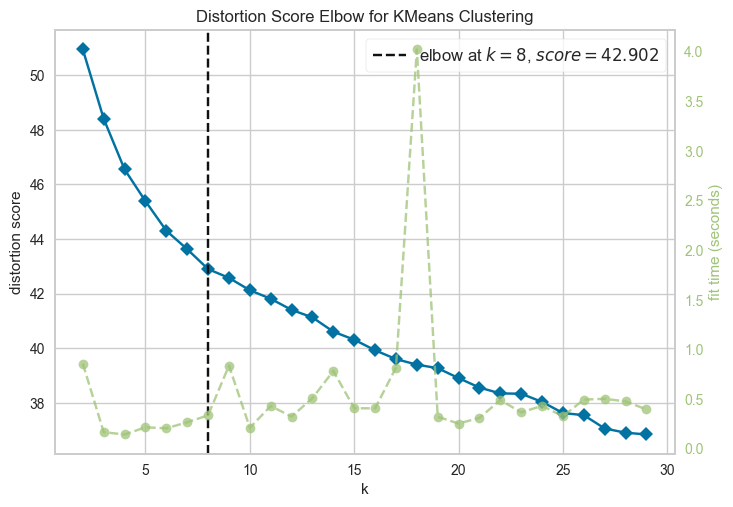

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
# referenced https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(en_text_array)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

In [49]:
en_df_clusters_laser = apply_cluster(en_text_array, en_df, en_filtered_comments, 10)

For n_clusters = 10
Silhouette coefficient: 0.03
Inertia:42.707401275634766
Silhouette values:
    Cluster 5: Size:16 | Avg:0.22 | Min:0.07 | Max: 0.34
    Cluster 8: Size:20 | Avg:0.09 | Min:-0.04 | Max: 0.22
    Cluster 3: Size:43 | Avg:0.09 | Min:-0.02 | Max: 0.13
    Cluster 7: Size:22 | Avg:0.05 | Min:-0.02 | Max: 0.10
    Cluster 6: Size:6 | Avg:0.02 | Min:-0.04 | Max: 0.06
    Cluster 0: Size:26 | Avg:0.00 | Min:-0.05 | Max: 0.06
    Cluster 1: Size:11 | Avg:-0.01 | Min:-0.09 | Max: 0.03
    Cluster 9: Size:40 | Avg:-0.01 | Min:-0.06 | Max: 0.06
    Cluster 2: Size:33 | Avg:-0.01 | Min:-0.06 | Max: 0.04
    Cluster 4: Size:63 | Avg:-0.02 | Min:-0.08 | Max: 0.06


In [50]:
en_df_clusters_laser[en_df_clusters_laser['cluster']==3]['text'].tolist()

['We are ready 💛💙❤️',
 '👏😄 next game please..⚽🏃',
 '@smithswith_ ❤️so good!!',
 '@jan_schawe to what 😂😂😂😂😂',
 '@5400.seconds are u there bro? 🤣',
 'Italy >>❤️',
 'Mount❤️',
 'Best player 🔥🔥',
 'He is completely right! 👏',
 'Brilliant player 👏🔥',
 'My Favorite team 🔥🔥',
 '@hana_photographyc 😂 Well done 👏',
 '@_hey.its.sup_ we did it 😉🙌',
 'hand ball 👏',
 '@realestate_topg what happened 🤣🤣',
 '@itsabdelfatah you were right 👏',
 'Nice game 🔥',
 '@beatbox_musicality For real bro🔥🔥🔥',
 '@kourosh_offiziell 🇧🇷🇧🇷🏆🏆🏆🏆🏆 🤫',
 '@ban_all_mondays verpiss dich goodbye😂',
 'the last one 💀',
 '@joyce_pecky they were well played🙌🏻🙌🏻',
 '@memphis is a lion 🦁🦁🦁',
 '@richard.escobarc by 😂😂🇲🇦💪',
 '@afaseleccion come back match💥💥💥',
 '@m.a.l.e.k.a.n.o_jr Just wait🔥',
 'Japan played better 😢',
 'Var 🖥 have another opinion 🤫',
 '@pictures_for_stickers Brazil 🇧🇷🛫🏠🤣🤣🤣🤣',
 '@its_romay 😢 me rn',
 '@ash.saalax 😂 what about it now',
 'We Respect Japan 🙌🙌🙌🔥🔥',
 'Meet you in final🙌🏻',
 'Cancel this game. 😒😒',
 'They k

In [51]:
en_df_clusters_laser[en_df_clusters_laser['cluster']==4]['text'].tolist()

['@bf_steve Who do you think I cheer for 😂',
 'Fantastis group..✌😄',
 'Netherlands👏👏👏 and also cricket',
 'This nikka sick wit it🔥😂',
 '@goodthanksyourself nice goal❤️',
 '@matheusgmezz u are goofy as heck😂',
 '@dashotb the comment I was looking for 😂',
 'One Love 🌈✖ 😂😂😂 one two ✔ 🤭🤭🤭',
 'We love you hazards🔥🔥🔥',
 'Gay people, they are my favorite 🌈🌈',
 '@afdhalulrizki42 😂 Stupid Football yes 😂',
 '@the_queen_of_adventure Haya bina ila lmondial 😂🇨🇲😍',
 'Bro was forced to do it😂😂😂😂😂',
 '@pr1ncesa_mar1 never! Korea is much better team! 👏',
 'dats literally my dad 🔥',
 'VAR only works for certain countries it seems 😢',
 'Morroco is the best 🇲🇦🖤',
 'Proudly Ghanaian 🇬🇭 🇬🇭 🇬🇭 🇬🇭 🇬🇭 ❤️',
 '@tina.f.aoun @gretta.khoury_ bs rebho aalaykun😂😂😂😂😂',
 '@samiath_bk 😂keep laughing Senegal is the best',
 'Musiala all the way🔥',
 'The Bluetooth goal 👏',
 '@zarbassir what I love to ear ❤️',
 'Loveee this ❤️',
 'CR7 ❤️🙌',
 '🇹🇳 ❤️🔥 should be proud 👏',
 'Wow very gorgeous ❤️🔥😍',
 '@blueblink5254 dude also, 

In [52]:
en_df_clusters_laser[en_df_clusters_laser['cluster']==6]['text'].tolist()

["Can't wait for this shitshow to be over and for next world cup. This one is such a waste 🗑 🙄. #nextplease #notoqatar2022 #boicotworldcup",
 'Congrats and well done to🇧🇪@belgianreddevils who wins and wish the best and good luck too in the next match against🇲🇦@equipedumaroc and for🇨🇦@canadasoccer ,well done for fights until the end despite lost and wish the best and good luck too in the next match against🇭🇷@hns_cff !👏🙂😀😄😎👍⚽️',
 'Dude… YOUR team was so rude and had poor sportsmanship. This new generation think they are entitled😡 Any other country would have been honored to be in the world cup to play on the same field with these GREAT players from 🇭🇷 \n\nI hope this humbles them. Canada player were acting like little brats. Croatia shut them up and put them on time out. Literally OUT😂💪🏻🇭🇷🇭🇷🇭🇷🇭🇷🇭🇷🇭🇷🏆🏆🏆🏆⚽️⚽️⚽️🇭🇷🇭🇷🇭🇷🇭🇷🇭🇷🇭🇷🇭🇷🇭🇷🇭🇷',
 "I'm heartbroken that we didn't do enough to go the next round, but in the end, we fought hard. 💔 And we're gonna continue fighting! They haven't seen the last 

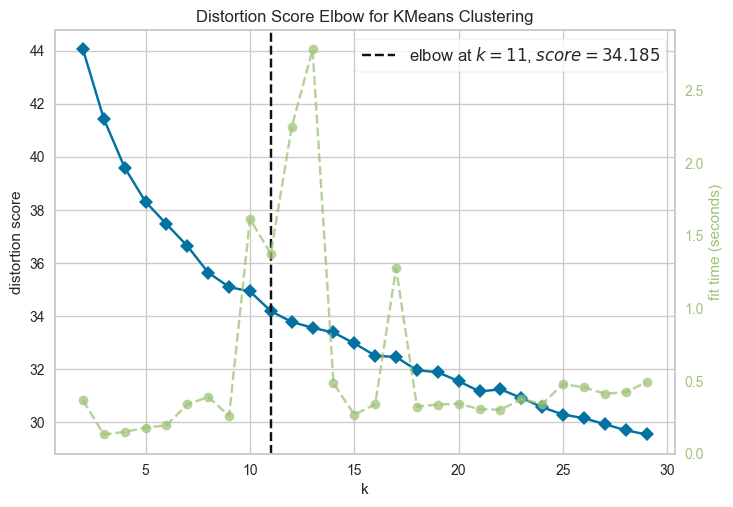

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [53]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(es_text_array)        # Fit data to visualizer
visualizer.show()     

In [54]:
es_df_clusters_laser = apply_cluster(es_text_array, es_df, es_filtered_comments, 8)

For n_clusters = 8
Silhouette coefficient: 0.05
Inertia:36.20710754394531
Silhouette values:
    Cluster 3: Size:31 | Avg:0.21 | Min:0.06 | Max: 0.34
    Cluster 5: Size:8 | Avg:0.15 | Min:-0.06 | Max: 0.25
    Cluster 1: Size:43 | Avg:0.07 | Min:-0.00 | Max: 0.17
    Cluster 0: Size:58 | Avg:0.07 | Min:-0.03 | Max: 0.13
    Cluster 7: Size:27 | Avg:0.02 | Min:-0.06 | Max: 0.11
    Cluster 2: Size:75 | Avg:0.00 | Min:-0.07 | Max: 0.08
    Cluster 4: Size:34 | Avg:-0.01 | Min:-0.09 | Max: 0.04
    Cluster 6: Size:4 | Avg:-0.02 | Min:-0.05 | Max: 0.01


In [55]:
# es_df_clusters_laser['translation'] = es_df_clusters_laser['text'].apply(lambda x: translator.translate(x))

In [56]:
es_df_clusters_laser[es_df_clusters_laser['cluster']==3]['text'].tolist()

['Corrupción 💰💰💰💰',
 '👏👏🙌🙌Ecuador',
 '@jctorr130 1-1🤫🤫🤫🤫',
 'Ronaldo🙌🔥',
 '@daje_mitico 😂😂',
 'Mechico 🤏🏼',
 '😂 Ronaldo',
 'Valencia🔥🔥🔥',
 '@andamente enormes 🙌🏼',
 'gracias 😍',
 '@luisitorres_ sí 🥵',
 'Mierda 😂😂😂😂😂😂😂😂',
 'Ronaldo🔥🔥🔥🔥',
 'El Plástico 🙌',
 '@guiguelpaulo 😢',
 'Argentina 🔥💚',
 '@caro2653 👏👏👏',
 '@_arabicqueen_ dream😂😂',
 'el mayor 🤩🤩',
 '😍ñ🔥🔥🔥',
 'Croacia 😂😂😂😂😂',
 'Nanicos⭐⭐🤏',
 'Paquetá 🥵',
 '@acdc.jpedro 😂😂😂😂😂',
 '@liga_profesional_de_truco 👍🏻',
 '😍ronaldo',
 '@b.local 😂😂😂👏',
 '@maxirodriguez11oficial genio!!! 👏👏👏👏💙🤍💙',
 'Marrocos👏👏👐👐',
 'Roberto 🔥🔥',
 '@laparra_1 👀']

In [57]:
es_df_clusters_laser[es_df_clusters_laser['cluster']==1]['text'].tolist()

['Vamos con todo 🇨🇷♥️⚽️',
 'Ecuador! 🇪🇨🇪🇨🇪🇨🇪🇨❤❤',
 '❤️❤️❤️❤️❤️❤️ Ecuatorianos 😍😍😍😍😍',
 'Cambien la bandera, somos Ecuador 🇪🇨☝🏻',
 'Con todo maes 🔥🇨🇷',
 'Nuestro último partido en un mundial 🇨🇴😢',
 'Go Ecuador 🇪🇨❤️',
 'Vamooo Halcón 🦅 🇺🇾',
 'Hola Buena noche es Portugal ⚽️👍🇵🇹',
 'Ame la camiseta de Francia 😍😍😍 🇺🇾🇨🇵',
 '@hichemourad13 será que sigue pensado igual este individuo?  Ecuador es grande 🇪🇨😉😉',
 'Para mi también sería como ver a Papa Noel! Te amamos Leo 🇦🇷⚽️💪🥰',
 'Anótalo papi .....Vamos Ecuador 🇪🇨🥰❤️❤️',
 'Ecuador presente 🇪🇨👏👏',
 'El gol del siglo 🇨🇷\U0001fae1',
 'Ecuador 🇪🇨 ❤️#win',
 '@bertonrayhs_ 😂😂😂la tenes adentro🇦🇷🇦🇷',
 '@sujo.beatz y nosotros 25 títulos 🏆 somos la selección más copera🇦🇷',
 '🕸️🤟🏻🇦🇷 La araña que pica @juliaanalvarez 🔥⚽💙',
 'Orgullo mexicano ❤️👏🏻🇲🇽',
 'Esta copa es tuya Leo 🇦🇷🙌',
 'El mejor del mundo mundial! ❤️\u200d🔥❤️\u200d🔥',
 "Y sólo tiene 21 años 😢 yo a los 21 estaba en un McDonald's 😂",
 'Argentina 🇦🇷🇦🇷💥💥💙',
 '@memphisdepay argentina 5 Holanda 1 😎'

## Clustering with LASER Embeddings on text + emoji

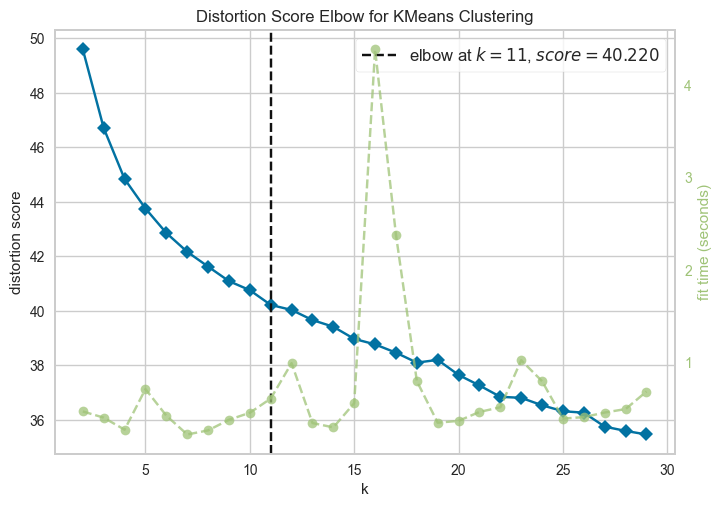

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [58]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(en_array)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

In [59]:
en_df_clusters_laser_with_emoji = apply_cluster(en_array, en_df, en_filtered_comments, 8)

For n_clusters = 8
Silhouette coefficient: 0.04
Inertia:41.72456359863281
Silhouette values:
    Cluster 4: Size:5 | Avg:0.17 | Min:0.06 | Max: 0.27
    Cluster 5: Size:38 | Avg:0.17 | Min:0.08 | Max: 0.29
    Cluster 2: Size:64 | Avg:0.08 | Min:-0.03 | Max: 0.16
    Cluster 6: Size:13 | Avg:0.04 | Min:-0.01 | Max: 0.09
    Cluster 0: Size:42 | Avg:0.02 | Min:-0.07 | Max: 0.10
    Cluster 7: Size:27 | Avg:-0.00 | Min:-0.06 | Max: 0.03
    Cluster 3: Size:45 | Avg:-0.02 | Min:-0.10 | Max: 0.06
    Cluster 1: Size:46 | Avg:-0.03 | Min:-0.09 | Max: 0.04


In [60]:
en_df_clusters_laser_with_emoji[en_df_clusters_laser_with_emoji['cluster']==1]['text'].tolist()

["Can't wait for this shitshow to be over and for next world cup. This one is such a waste 🗑 🙄. #nextplease #notoqatar2022 #boicotworldcup",
 'You are the best lady😻🤩🙏👏♥️⚽🤠fifa.',
 '@itisjuanderful AAJAA POR NO PERMITIR GAYS EN LA COPA MUNDIAL YO LO VEO EXCELENTE👏🔥',
 'Rainbow 🌈🌈🌈 shame on fifa',
 'Yes 2022 is different because Argentina will not go in round of 16 😂',
 'no bro many moroccans respect Croatia team, was a game full of fair-play 👌🏽',
 'Wtf Mbappe wasn’t even the man of the match 🤦🏻\u200d♂️',
 "@shintia97s love over hate !! I'm sorry that you've got so much anger inside for another human. But I forgive you and send you love and support. 🫂🫂🤗🤗😘😘🏳️\u200d🌈🏳️\u200d🌈",
 'But you start to tremble knowing you face Saudi Arabia 🇸🇦 😆',
 "Hazard's the only reason im a chelsea fan 🐐💙",
 '@gokselinia they all good, u are the one being racist u woman with cartoon tshirt or I say Karen👩🏻\u200d🦰',
 'This is an insult\nWe lost because of their support🤦\u200d♂️',
 'Wow nice moves robo😍😍😍😍😍😍😍

In [61]:
en_df_clusters_laser_with_emoji[en_df_clusters_laser_with_emoji['cluster']==5]['text'].tolist()

['Son🥺',
 '@_francechy_ 🤣🤣🤣',
 '@goodthanksyourself nice goal❤️',
 '@smithswith_ ❤️so good!!',
 '@jan_schawe to what 😂😂😂😂😂',
 '@5400.seconds are u there bro? 🤣',
 'Italy >>❤️',
 'Mount❤️',
 'He is completely right! 👏',
 '@hana_photographyc 😂 Well done 👏',
 '@_hey.its.sup_ we did it 😉🙌',
 '@tina.f.aoun @gretta.khoury_ bs rebho aalaykun😂😂😂😂😂',
 'hand ball 👏',
 'Rushford 🔥',
 '@realestate_topg what happened 🤣🤣',
 'Loveee this ❤️',
 '@itsabdelfatah you were right 👏',
 'CR7 ❤️🙌',
 'Nice game 🔥',
 '@kourosh_offiziell 🇧🇷🇧🇷🏆🏆🏆🏆🏆 🤫',
 '@anchan_0722_ 😂😂😂',
 '@88godiswithme 😂😂😂😂😂😂😂 congratulations!!',
 'the last one 💀',
 'Congratulations 🔥👏',
 'respect 👏',
 'Cool🔥',
 '@spasho05 😂😂😂😂',
 '@m.a.l.e.k.a.n.o_jr Just wait🔥',
 'HE SO FINE OMLL 😍',
 '@its_romay 😢 me rn',
 'Caption 💯',
 '@robertmikocevic yes 😉😉🔥',
 'Follow @__footycontent_ 😍',
 'They kost💀',
 '@shreyanshpathak8717 😂',
 '@guilherme_tornich 💪🇦🇷🇦🇷🇦🇷😂😂',
 '@fabreezy_ 👏👏👏 this is yours???',
 '@k.mbappe proud of you👏']

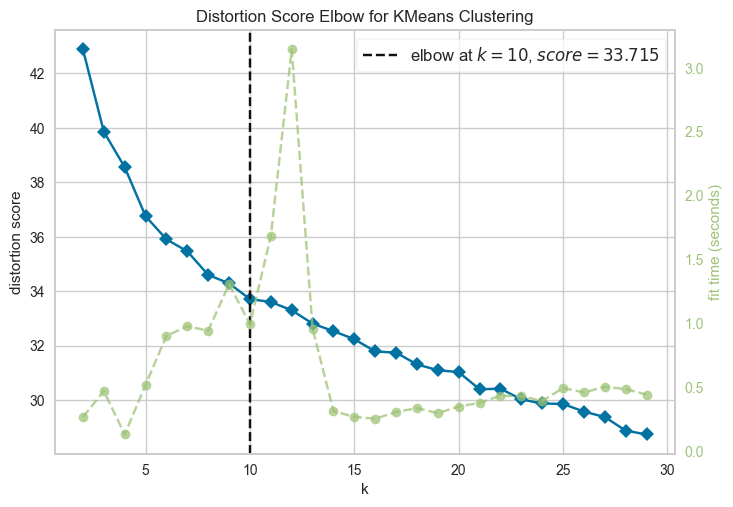

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [62]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(es_array)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

In [63]:
es_df_clusters_laser_with_emoji = apply_cluster(es_array, es_df, es_filtered_comments, 8)

For n_clusters = 8
Silhouette coefficient: 0.03
Inertia:35.527523040771484
Silhouette values:
    Cluster 0: Size:12 | Avg:0.18 | Min:0.06 | Max: 0.30
    Cluster 6: Size:10 | Avg:0.13 | Min:-0.13 | Max: 0.26
    Cluster 5: Size:10 | Avg:0.13 | Min:0.07 | Max: 0.20
    Cluster 3: Size:56 | Avg:0.09 | Min:-0.02 | Max: 0.19
    Cluster 7: Size:52 | Avg:0.06 | Min:-0.04 | Max: 0.13
    Cluster 2: Size:55 | Avg:-0.02 | Min:-0.09 | Max: 0.04
    Cluster 1: Size:55 | Avg:-0.04 | Min:-0.19 | Max: 0.09
    Cluster 4: Size:30 | Avg:-0.05 | Min:-0.13 | Max: 0.03


In [64]:
es_df_clusters_laser_with_emoji[es_df_clusters_laser_with_emoji['cluster']==3]['text'].tolist()

['Vamos con todo 🇨🇷♥️⚽️',
 'Corrupción 💰💰💰💰',
 'Con todo maes 🔥🇨🇷',
 '👏👏🙌🙌Ecuador',
 '@jctorr130 1-1🤫🤫🤫🤫',
 'Go Ecuador 🇪🇨❤️',
 'Ronaldo🙌🔥',
 'Eden hazard comes back😍😍😍',
 '¡El mago maestro🔥🔥🤍👏🏻⚡',
 'Te amamos @yosoy8a 🇲🇽🔥',
 'Mechico 🤏🏼',
 '@jl5759600 telo sico 🤫🤐',
 'Vamooo Halcón 🦅 🇺🇾',
 'Hola Buena noche es Portugal ⚽️👍🇵🇹',
 '@sandra_cariel cameeron 100% éliminer 🔥🔥',
 '15 mundiales 👏👏👏',
 'Seraaa que rompen la maldición🔥🔥🔥',
 'Valencia🔥🔥🔥',
 'Lol Casillas!!! 😍😍',
 '_Marocoo🇲🇦🫀_',
 'Ecuador presente 🇪🇨👏👏',
 'El gol del siglo 🇨🇷\U0001fae1',
 '"Maurice ya no puedo moverlo mover moverlo" ❌🦵😭',
 '@andamente enormes 🙌🏼',
 'Ecuador 🇪🇨 ❤️#win',
 '@bertonrayhs_ 😂😂😂la tenes adentro🇦🇷🇦🇷',
 '🕸️🤟🏻🇦🇷 La araña que pica @juliaanalvarez 🔥⚽💙',
 'la araña que pica🤘🏻🕷️',
 'Ronaldo🔥🔥🔥🔥',
 'Orgullo mexicano ❤️👏🏻🇲🇽',
 'Que bueno que sos 😭😭😭',
 '@hilla_loaiza que nivel 🔥🔥🔥',
 'Argentina 🔥💚',
 '@marqu3si yo bro chill 👏🔥',
 'Grande el matemático.🙌🏽👏🏽',
 'Esta copa es tuya Leo 🇦🇷🙌',
 'el mayor 🤩🤩',
 'Un gra

In [65]:
es_df_clusters_laser_with_emoji[es_df_clusters_laser_with_emoji['cluster']==4]['text'].tolist()

['Cambien la bandera, somos Ecuador 🇪🇨☝🏻',
 'Felicidades a Ecuador por ganarle a los esclavistas 👏🏼👏🏼',
 'love banget idola saya portugal - cristiano ronaldo.😍',
 '@magggitomcruz ya estamos en la copa, se llama USA 🇺🇸 lmao p3nd3j0 😂😂',
 '@hichemourad13 será que sigue pensado igual este individuo?  Ecuador es grande 🇪🇨😉😉',
 'Toda mí fe para la Argentina 🔥',
 '@borenia grs!!! 🔥🙌❤️ futbol es fútbol',
 'Anótalo papi .....Vamos Ecuador 🇪🇨🥰❤️❤️',
 '@deyaneira_ae que habilitacion se mando valencia en el 2do gol de Senegal🙌🔥🔥',
 '@sujo.beatz y nosotros 25 títulos 🏆 somos la selección más copera🇦🇷',
 'Maradona lo ayudar a Messi para lograr el triunfo ❤️👏👏👏',
 '@chucuzilla la mas grande conquista de Vargentina against Brasil ? 😂👌🏼 Pelé es maior que lá Vargentina 😂',
 'Los trios siempre son buenos bro 🔥😉',
 'Argentina 🇦🇷🇦🇷💥💥💙',
 '@memphisdepay argentina 5 Holanda 1 😎',
 'Inglaterra se cae a pedazos 🥱, las Malvinas son argentinas salames',
 'ComOn argentina..you can do it 🔥❤️🔥',
 '@keylor_ch29 hac

# Visualize Clusters 🎨

In [66]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#### English

In [72]:
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(en_embeddings)

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(principalComponents)

en_df_clusters = en_df_clusters.reset_index()
en_df_clusters = en_df_clusters.drop(['index'], axis=1)

tsne_df = en_df_clusters
tsne_df['PC1'] = tsne_pca_results[:,0]
tsne_df['PC2'] = tsne_pca_results[:,1]

<Axes: xlabel='PC1', ylabel='PC2'>

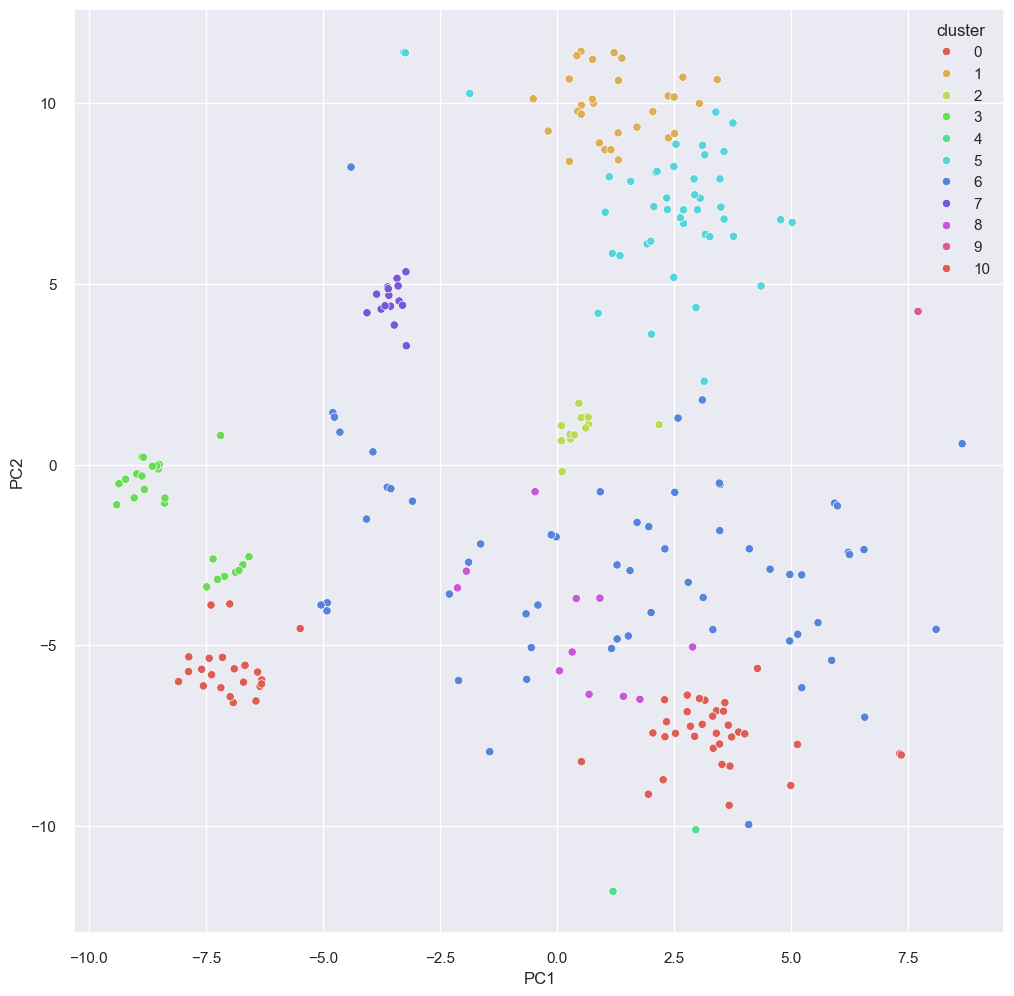

In [73]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(data=tsne_df, x='PC1', y='PC2', hue='cluster', palette=sns.color_palette("hls",10), legend="full")

#### Spanish

In [74]:
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(es_embeddings)

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(principalComponents)

es_df_clusters = es_df_clusters.reset_index()
es_df_clusters = es_df_clusters.drop(['index'], axis=1)

tsne_df = es_df_clusters
tsne_df['PC1'] = tsne_pca_results[:,0]
tsne_df['PC2'] = tsne_pca_results[:,1]

<Axes: xlabel='PC1', ylabel='PC2'>

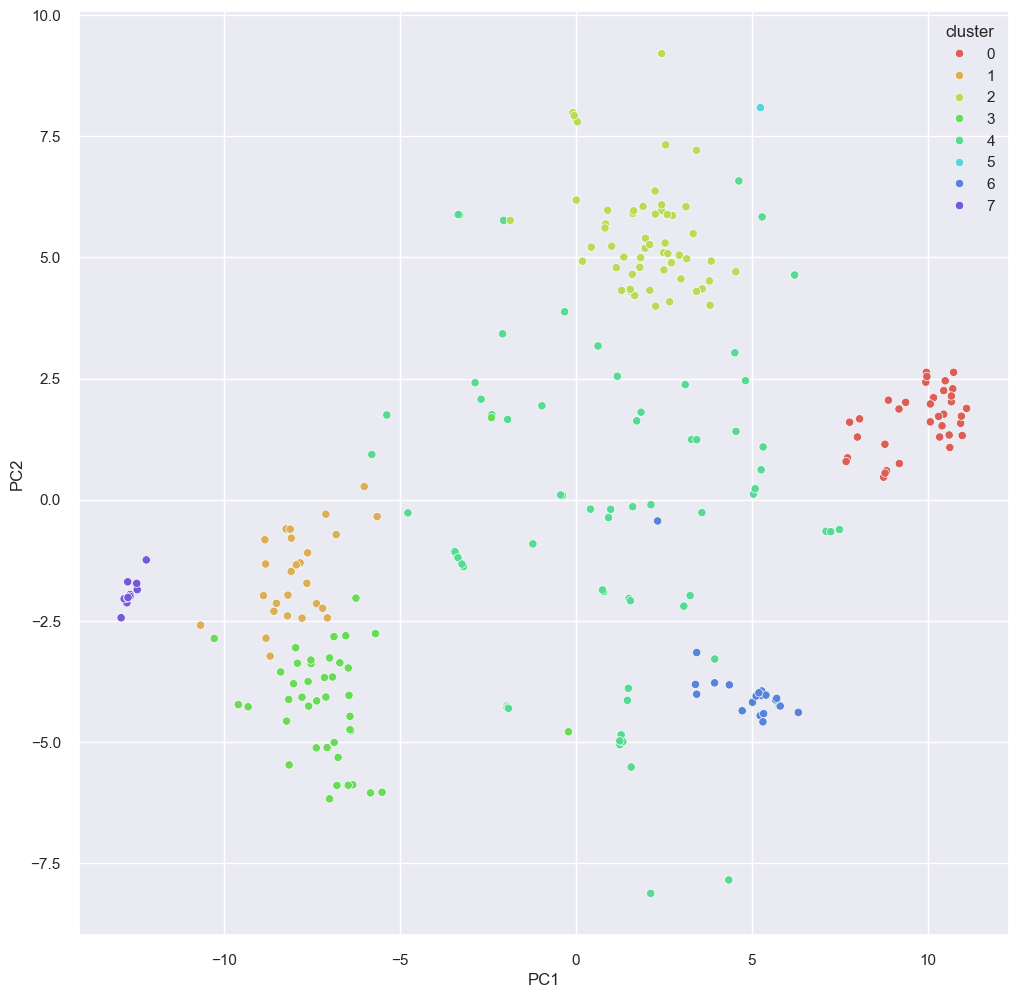

In [75]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(data=tsne_df, x='PC1', y='PC2', hue='cluster', palette=sns.color_palette("hls",10), legend="full")

<Axes: xlabel='PC1', ylabel='PC2'>

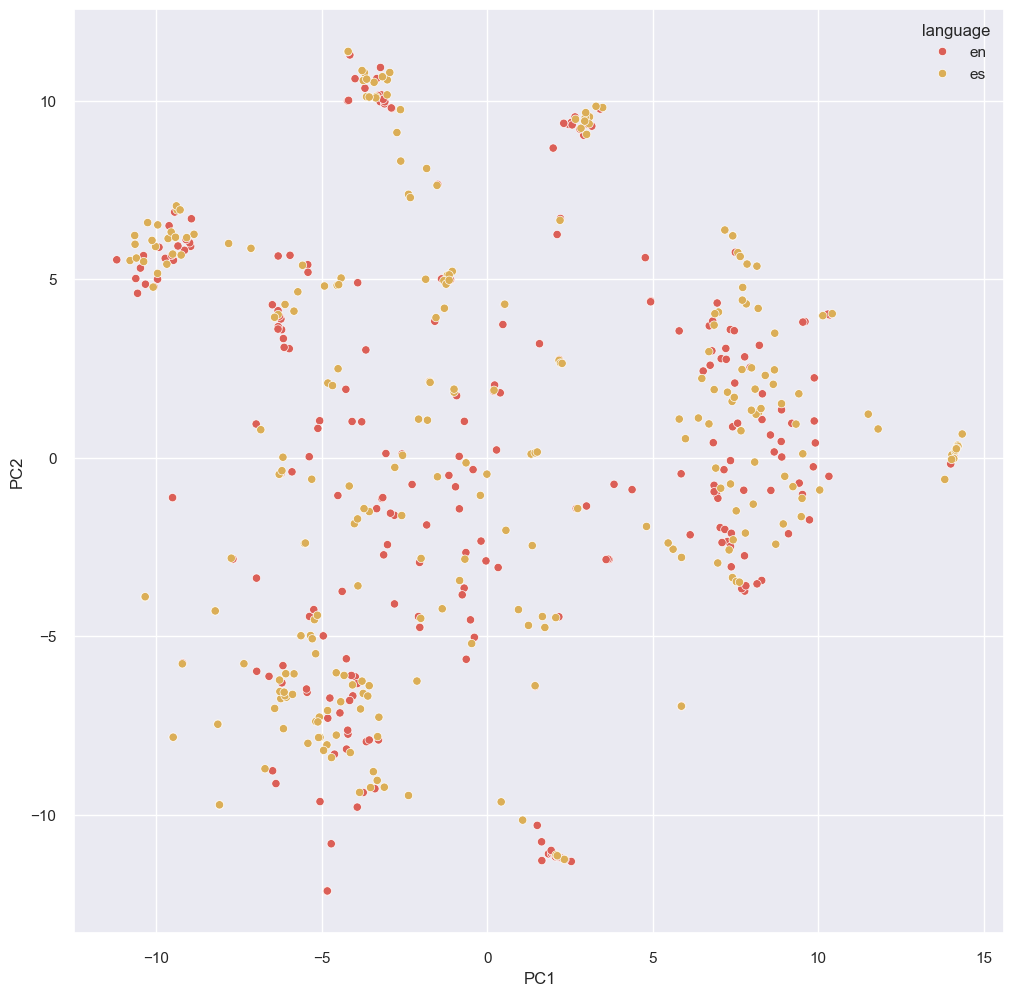

In [71]:
both_embeddings = np.concatenate((en_embeddings, es_embeddings))

pca = PCA(n_components=50)
principalComponents = pca.fit_transform(both_embeddings)

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(principalComponents)

tsne_df = pd.concat([en_df_clusters, es_df_clusters])
tsne_df['PC1'] = tsne_pca_results[:,0]
tsne_df['PC2'] = tsne_pca_results[:,1]

tsne_df = tsne_df.reset_index()

for idx, row in tsne_df.iterrows():
    if idx < 280:
        tsne_df.at[idx, 'language'] = 'en'
    else:
        tsne_df.at[idx, 'language'] = 'es'

sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(data=tsne_df, x='PC1', y='PC2', hue='language', palette=sns.color_palette("hls",10), legend="full")